# Evaluate sampling representation of the ship track
- Extract data from MIMIC-TPW, IMERG and ERA-5 along the ship track
- Compare actual data to MIMIC-TPW, IMERG and ERA-5 along ship track to MIMIC-TPW, IMERG and ERA-5 over the whole region
- Compare sampling along planned and actual track

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from scipy.interpolate import interp2d, RectBivariateSpline
from datetime import datetime, timedelta
import pandas as pd
import cftime
import seaborn as sns
import json
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy
import seaborn as snt
from thermo_functions import *
from time_series_diag import *
from bowtie_read_data import *

In [2]:
#Set start and end times and box
lat1 = 4.5
lat2 = 17
lon1 = -60
lon2 = -22

start_time = np.datetime64('2024-08-16T07:00:00')
end_time = np.datetime64('2024-09-23T22:00:00')

# SHIP DATA

In [3]:
#Open DSHIP data
DSHIP = xr.open_dataset('/huracan/tank1/work/ORCESTRA/M203/Dship_data/data/meteor_meteo_dship_20240923.nc')

In [4]:
#Interpolate DSHIP data to hourly resolution
#could use 30 minute for IMERG, but MIMIC-TPW and ERA-5 are only hourly

ship_time_interp = pd.date_range(start_time, end_time, freq='h')
ship_lat_interp = np.interp(ship_time_interp,DSHIP.time,DSHIP.lat)
ship_lon_interp = np.interp(ship_time_interp,DSHIP.time,DSHIP.lon)

In [ ]:
#Planned track
# Load JSON data from a file
with open('../track_planned.json', 'r') as file:
    planned_track = json.load(file)

# Convert JSON data to a DataFrame
planned_track_df = pd.DataFrame(planned_track)

#Convert track_time to datetime
planned_track_df['track_time'] = pd.to_datetime(planned_track_df['track_time'])

#Convert DataFrame to xarray.Dataset
planned_track_ds = planned_track_df.set_index('track_time').to_xarray()

#Interpolate planned track to hourly times
start_time_planned = np.datetime64('2024-08-10T12:00:00')
end_time_planned = np.datetime64('2024-09-23T20:00:00')

planned_time_interp = pd.date_range(start_time_planned, end_time_planned, freq='h')
planned_lat_interp = np.interp(planned_time_interp, planned_track_ds.track_time, planned_track_ds.track_lat)
planned_lon_interp = np.interp(planned_time_interp, planned_track_ds.track_time, planned_track_ds.track_lon)

#check that it interpolated correctly
plt.plot(planned_lon_interp, planned_lat_interp,'o')
plt.plot(planned_track_ds.track_lon, planned_track_ds.track_lat,'-')
plt.plot(ship_lon_interp, ship_lat_interp,'o')
plt.plot(DSHIP.lon, DSHIP.lat,'-')

# SATELLITE DATA

In [5]:
# Load MIMIC-TPW data
mimic = xr.open_dataset('/huracan/tank1/work/ORCESTRA/mimic-tpw/mimic_tpw_20240809.nc')

# Load IMERG data
imerg = xr.open_dataset('/huracan/tank1/work/ORCESTRA/imerg/imerg_20240809.nc')

# Convert cftime.DatetimeJulian to pandas.DatetimeIndex
imergtimes = imerg['time'].values
imergtimes_converted = pd.to_datetime([t.strftime('%Y-%m-%d %H:%M:%S') for t in imergtimes])
imerg['time'] = imergtimes_converted

# Coarsen IMERG from 0.10 degree to the same 0.25 degree resolution as ERA-5 (or close to it) and from 30-minutes to hourly
imerg_coarse = imerg.coarsen(lon=int(0.25/0.1),lat=int(0.25/0.1),boundary='pad').mean()
imerg_coarse = imerg.coarsen(time=2,boundary='pad').mean()

imerg_coarse

<xarray.Dataset> Size: 5GB
Dimensions:        (time: 1464, nv: 2, lon: 1500, lonv: 2, lat: 600, latv: 2)
Coordinates:
  * time           (time) datetime64[ns] 12kB 2024-08-01T00:15:00 ... 2024-09...
  * lon            (lon) float32 6kB -89.95 -89.85 -89.75 ... 59.75 59.85 59.95
  * lat            (lat) float32 2kB -9.95 -9.85 -9.75 ... 49.75 49.85 49.95
Dimensions without coordinates: nv, lonv, latv
Data variables:
    time_bnds      (time, nv) object 23kB 2024-08-01 00:15:00 ... 2024-09-30 ...
    lon_bnds       (time, lon, lonv) float32 18MB -90.0 -89.9 ... 59.9 60.0
    lat_bnds       (time, lat, latv) float32 7MB -10.0 -9.9 -9.9 ... 49.9 50.0
    precipitation  (time, lat, lon) float32 5GB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    GridHeader:  BinMethod=ARITHMETIC_MEAN;\nRegistration=CENTER;\nLatitudeRe...

(0.0, 20.0)

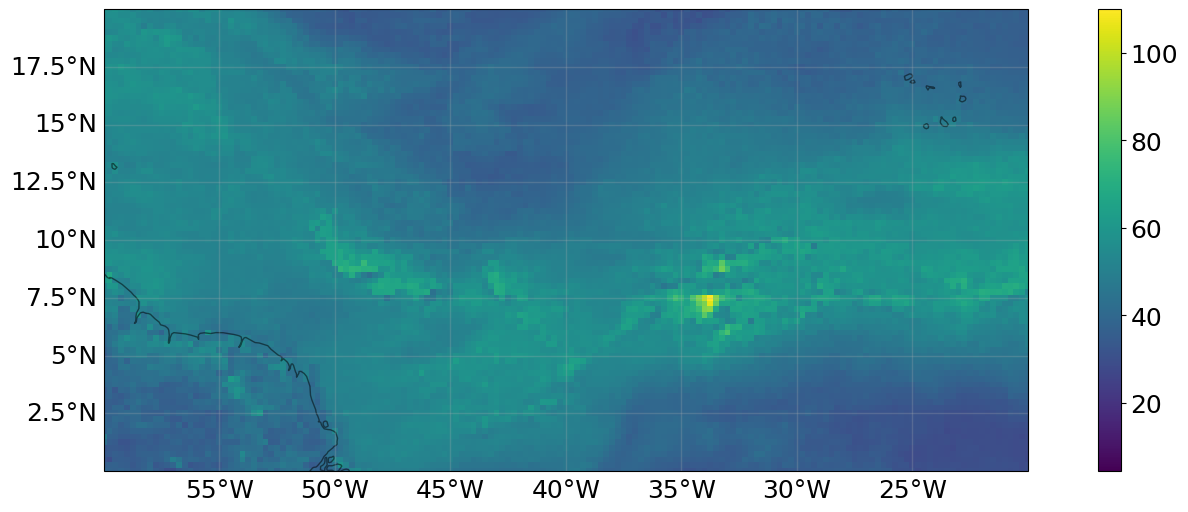

In [6]:
# Test plot of MIMIG-TPW
 
plt.figure(figsize=(18,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution = '50m',alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
gl.top_labels = False
gl.right_labels = False
#gl.xlocator = mticker.FixedLocator([-50, -40, -30, -20, -10, 0, 10])
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18}
gl.ylabel_style = {'size': 18}

plt.pcolormesh(mimic.lon.values,mimic.lat.values,mimic.tpwGrid[0,:,:])

cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=18)

ax.set_xlim(-60,-20)
ax.set_ylim(0,20)



(0.0, 20.0)

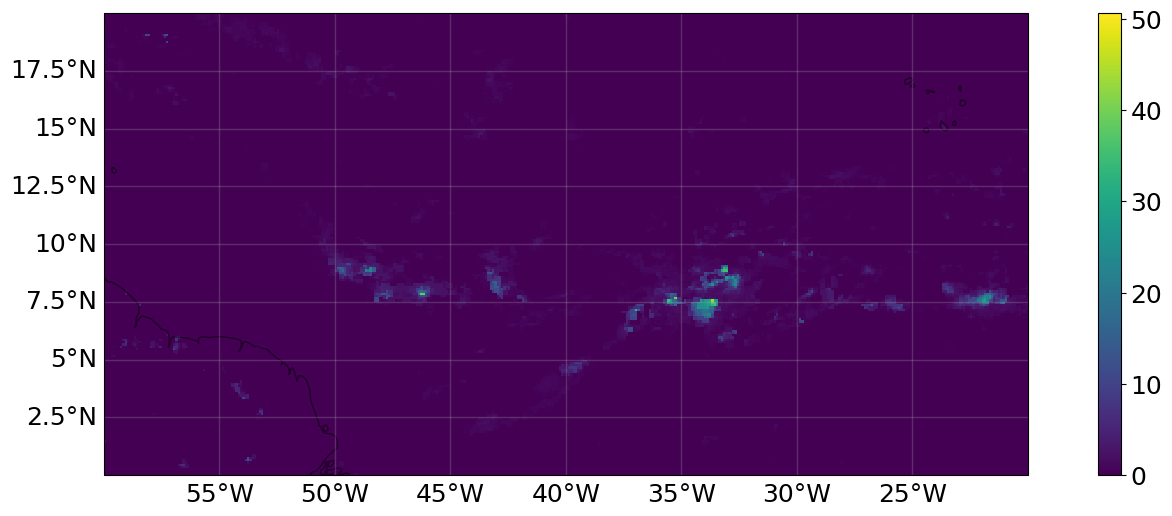

In [7]:
# Test plot of IMERG
 
plt.figure(figsize=(18,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution = '50m',alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
gl.top_labels = False
gl.right_labels = False
#gl.xlocator = mticker.FixedLocator([-50, -40, -30, -20, -10, 0, 10])
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18}
gl.ylabel_style = {'size': 18}

plt.pcolormesh(imerg.lon.values,imerg.lat.values,imerg.precipitation[0,:,:])

cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=18)

ax.set_xlim(-60,-20)
ax.set_ylim(0,20)



# ERA-5 REANALYSIS DATA

In [8]:
#Open ERA-5 Data
era5 = xr.open_dataset('/huracan/tank1/work/ORCESTRA/era5/ERA5_hrly_OLR_Prec_PW_20240809.nc')
era5

<xarray.Dataset> Size: 4GB
Dimensions:     (valid_time: 1464, latitude: 241, longitude: 601)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 12kB 2024-08-01 ... 2024-09-30T23...
  * latitude    (latitude) float64 2kB 50.0 49.75 49.5 ... -9.5 -9.75 -10.0
  * longitude   (longitude) float64 5kB -90.0 -89.75 -89.5 ... 59.5 59.75 60.0
    expver      (valid_time) <U4 23kB ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 848MB ...
    mtpr        (valid_time, latitude, longitude) float32 848MB ...
    mtnlwrf     (valid_time, latitude, longitude) float32 848MB ...
    ttr         (valid_time, latitude, longitude) float32 848MB ...
    tcwv        (valid_time, latitude, longitude) float32 848MB ...
Attributes:
    GRIB_centre:                ecmf
    GRIB_centreDescription:     European Centre for Medium-Range Weather Fore...
    GRIB_subCentre:             0
    Conventions:                CF-1.7
    institution:                European Centre for Medium-Range Weather Fore...
    history:                    Mon Nov 11 14:56:15 2024: ncks -A -v tcwv ERA...
    history_of_appended_files:  Mon Nov 11 14:56:15 2024: Appended file ERA5_...
    NCO:                        netCDF Operators version 5.1.5 (Homepage = ht...

# Extract data along ship track

Put IMERG data on MIMIC-TPW grid

In [9]:
imerg_grid = imerg.interp(lat=mimic.lat,lon=mimic.lon,method='linear') #interpolate to mimic grid
imerg_grid_coarse = imerg_grid.coarsen(time=2,boundary='pad').mean() #coarsen to hourly
imerg_grid_coarse = imerg_grid_coarse.interp(time=mimic.time,method='linear') #interpolate to mimic times

Extract data from MIMIC-TPW and IMERG along ship track

In [10]:
PW_alongtrack = np.full(len(ship_lat_interp),np.nan)
prec_alongtrack = np.full(len(ship_lat_interp),np.nan)

for itime in range(0,len(ship_lat_interp)):
    PW_alongtrack[itime] = mimic.tpwGrid.sel(lat=ship_lat_interp[itime],lon=ship_lon_interp[itime], time=ship_time_interp[itime],method='nearest')
    prec_alongtrack[itime] = imerg_grid_coarse.precipitation.sel(lat=ship_lat_interp[itime],lon=ship_lon_interp[itime], time=ship_time_interp[itime],method='nearest')

Extract ERA-5 data along ship track

In [11]:
PW_alongtrack_era5 = np.full(len(ship_lat_interp),np.nan)
prec_alongtrack_era5 = np.full(len(ship_lat_interp),np.nan)

for itime in range(0,len(ship_lat_interp)):
    PW_alongtrack_era5[itime] = era5.tcwv.sel(latitude=ship_lat_interp[itime],longitude=ship_lon_interp[itime], valid_time=ship_time_interp[itime],method='nearest')
    prec_alongtrack_era5[itime] = era5.mtpr.sel(latitude=ship_lat_interp[itime],longitude=ship_lon_interp[itime], valid_time=ship_time_interp[itime],method='nearest')

# Compare to radiosonde data
Read in radiosonde data

In [12]:
# Soundings
snd_asc, snd_files, times_asc = read_bowtie_soundings(search_string = 'ascen')
# soundings, snd_files, times_snd = read_bowtie_soundings(search_string = 'descen')
hght = snd_asc['hght']

In [13]:
# Vertical mass-weighted integral
#   inputs:
#       tmpk:   temperature [K]
#       mr:     water vapor mixing ratio [kg/kg]
#       p:      pressure [Pa]
#       hght:   height [m]
#   options:
#       minpres: set this to minimum pressure to integrate over [Pa]
def vert_integral(invar, tmpk, mr, p, hght, minpres=0):
    rho = density_moist(tmpk, mr, p) # kg/m3
    dz = hght[1]-hght[0] # m
    var_int = np.nansum(invar*rho, axis=1, where=(p > minpres))*dz
    var_int[ np.where(var_int == 0) ] = np.nan
    return var_int

Calculate column-integrated water vapor

In [14]:
# Constants
cp=1004.  # J/K/kg
cpl=4186. # J/k/kg
cpv=1885. # J/K/kg
lv0=2.5e6 # J/kg
g = 9.81 # m/s2
# Latent heat of vaporization
lv = lv0 - (cpl-cpv)*(snd_asc['tmpk']-273.15)

In [15]:
# CWV/PW
# 1/g int(q)dp = s2/m * kg/m/s2 --> kg/m2 --> x1/rho_l --> 10^-3 kg/m2*m3/kg --> 10^-3m = mm
# int<q*rho>dz = kg/m3*m = kg/m2 = mm
cwv = vert_integral(snd_asc['mr'], snd_asc['tmpk'], snd_asc['mr'], snd_asc['p'],
                    hght, minpres=0) # mm or kg/m2

In [16]:
#Mask out soundings that don't reach 100 hPa
 
nt = snd_asc['p'].shape[0]
min_pres = np.zeros(nt)
for isnd in range(nt):
    min_pres[isnd] = np.nanmin(snd_asc['p'][isnd,:]*1e-2) # Pa --> hPa
cwv = np.ma.masked_where((min_pres > 100), cwv, copy=False)

/tmp/ipykernel_286052/1962452099.py:6: RuntimeWarning: All-NaN slice encountered
  min_pres[isnd] = np.nanmin(snd_asc['p'][isnd,:]*1e-2) # Pa --> hPa


In [28]:
# Convert datetime arrays to numeric type (minutes since a reference time)
ref_time = np.datetime64('1970-01-01T00:00:00')
times_asc_minutes = (times_asc - ref_time) / np.timedelta64(1, 'm')
DSHIP_time_minutes = (DSHIP.time - ref_time) / np.timedelta64(1, 'm')

# Mask out soundings before start_time
cwv = np.ma.masked_where(times_asc < start_time, cwv, copy=False)

finite = np.where(np.isfinite(cwv))
cwv_finite = cwv[finite]


Text(0.5, 1.0, 'Column-Integrated Water Vapor Along Ship Track')

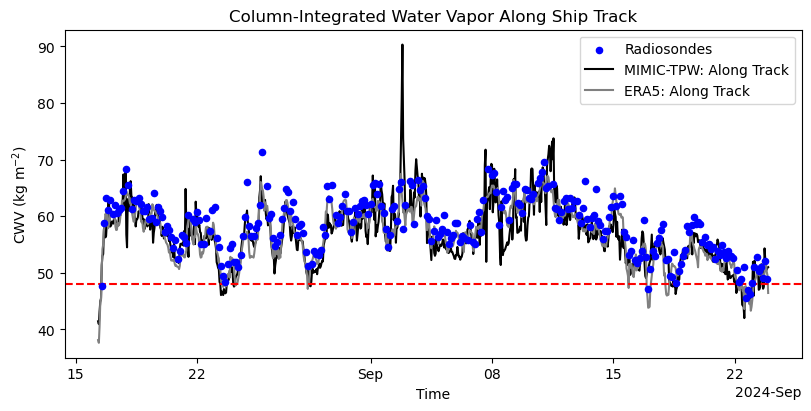

In [29]:
#plot timeseries of CWV along ship track from ERA-5 and MIMIC-TPW (interpolated to hourly ship positions) and radiosondes

fig,ax = plt.subplots(figsize=(8,4),layout="constrained")

#radiosonde data
ax.scatter(times_asc[finite],cwv_finite,marker='o',color='blue',s=20,label='Radiosondes',zorder=3)
ax.plot(ship_time_interp,PW_alongtrack,'k',label='MIMIC-TPW: Along Track',zorder=1)
ax.plot(ship_time_interp,PW_alongtrack_era5,'gray',label='ERA5: Along Track',zorder=2)
#ax.plot(planned_time_interp,PW_alongtrack_planned,'gray',label='Planned Track')
ax.axhline(48,color='red',linestyle='--')  

plt.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_xlabel('Time')
ax.set_ylabel('CWV (kg m$^{-2}$)')
ax.set_title('Column-Integrated Water Vapor Along Ship Track')

#fig.savefig('../figures/Fig_CWV_alongtrack_timeseries.png')

Collect data at all times throughout ship track and all locations within box of interest

In [18]:
#Collect MIMIC data at all times throughout ship track and all locations within box of interest
PW_box = mimic.tpwGrid.sel(lat=slice(lat1,lat2), lon=slice(lon1,lon2),time=slice(start_time,end_time))
PW_bigbox = mimic.tpwGrid.sel(lat=slice(0,20), lon=slice(-60,-20),time=slice(start_time,end_time))

In [19]:
#Collect IMERG data at all times throughout ship track and all locations within box of interest
prec_box = imerg_grid_coarse.precipitation.sel(lat=slice(lat1,lat2), lon=slice(lon1,lon2),time=slice(start_time,end_time))
prec_bigbox = imerg_grid_coarse.precipitation.sel(lat=slice(0,20), lon=slice(-60,-20),time=slice(start_time,end_time))

In [20]:
#Collect ERA-5 data at all times throughout ship track and all locations within box of interest
PW_box_era5 = era5.tcwv.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2), valid_time=slice(start_time,end_time))
PW_bigbox_era5 = era5.tcwv.sel(latitude=slice(20,0), longitude=slice(-60,-20), valid_time=slice(start_time,end_time))
prec_box_era5 = era5.mtpr.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2), valid_time=slice(start_time,end_time))
prec_bigbox_era5 = era5.mtpr.sel(latitude=slice(20,0), longitude=slice(-60,-20), valid_time=slice(start_time,end_time))

Evaluate sampling distribution of ship track compared to full region

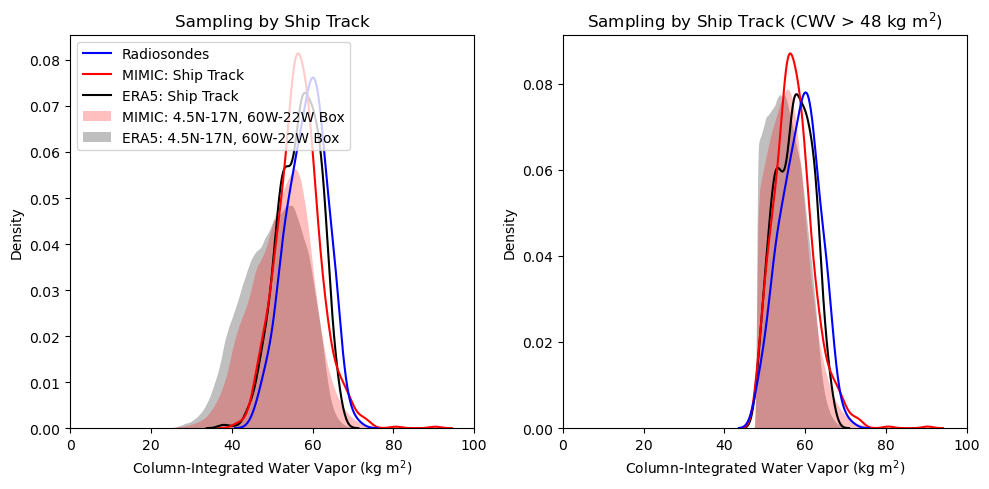

In [24]:
# Create probability density plots

fig, axs = plt.subplots(1,2,figsize=(10,5))

sns.kdeplot(cwv_finite,ax=axs[0],label='Radiosondes',fill=False,color='blue',zorder=5)
sns.kdeplot(PW_alongtrack,ax=axs[0],label='MIMIC: Ship Track',fill=False, color='red',zorder=4)
sns.kdeplot(PW_alongtrack_era5,ax=axs[0],label='ERA5: Ship Track',fill=False, color='black',zorder=3)
sns.kdeplot(PW_box.values.flatten(),ax=axs[0],label='MIMIC: 4.5N-17N, 60W-22W Box',fill=True,color='red',alpha=0.25,linewidth=0,zorder=2)
#sns.kdeplot(PW_bigbox.values.flatten(),ax=axs[0],label='MIMIC: 0N-20N, 60W-20W Box',fill=True,color='orange',zorder=1)
sns.kdeplot(PW_box_era5.values.flatten(),ax=axs[0],label='ERA5: 4.5N-17N, 60W-22W Box',fill=True,color='black',alpha=0.25,linewidth=0,zorder=1)
#sns.kdeplot(PW_bigbox_era5.values.flatten(),ax=axs[0],label='ERA5: 0N-20N, 60W-20W Box',fill=True,color='green',zorder=1)

axs[0].set_title('Sampling by Ship Track')
axs[0].set_xlabel('Column-Integrated Water Vapor (kg m$^2$)')
axs[0].set_ylabel('Density')
axs[0].legend(loc='upper left')
axs[0].set_xlim(0,100)

sns.kdeplot(cwv_finite[cwv_finite>48],ax=axs[1],label='Radiosondes',fill=False,color='blue',zorder=5)
sns.kdeplot(PW_alongtrack[PW_alongtrack>48],ax=axs[1],label='MIMIC: Ship Track',fill=False, color='red',zorder=4)
sns.kdeplot(PW_alongtrack_era5[PW_alongtrack_era5>48],ax=axs[1],label='ERA5: Ship Track',fill=False, color='black',zorder=3)
sns.kdeplot(PW_box.values[PW_box.values>48],ax=axs[1],label='MIMIC: 4.5N-17N, 60W-22W Box',fill=True,color='red',alpha=0.25,linewidth=0,zorder=2)
sns.kdeplot(PW_box_era5.values[PW_box_era5.values>48],ax=axs[1],label='ERA5: 4.5N-17N, 60W-22W Box',fill=True,color='black',alpha=0.25,linewidth=0,zorder=1)

axs[1].set_title('Sampling by Ship Track (CWV > 48 kg m$^2$)')
axs[1].set_xlabel('Column-Integrated Water Vapor (kg m$^2$)')
axs[1].set_ylabel('Density')
#axs[1].legend(loc='upper left')
axs[1].set_xlim(0,100)

plt.tight_layout()
plt.show()

fig.savefig('../figures/Fig_CWV_sampling.png')

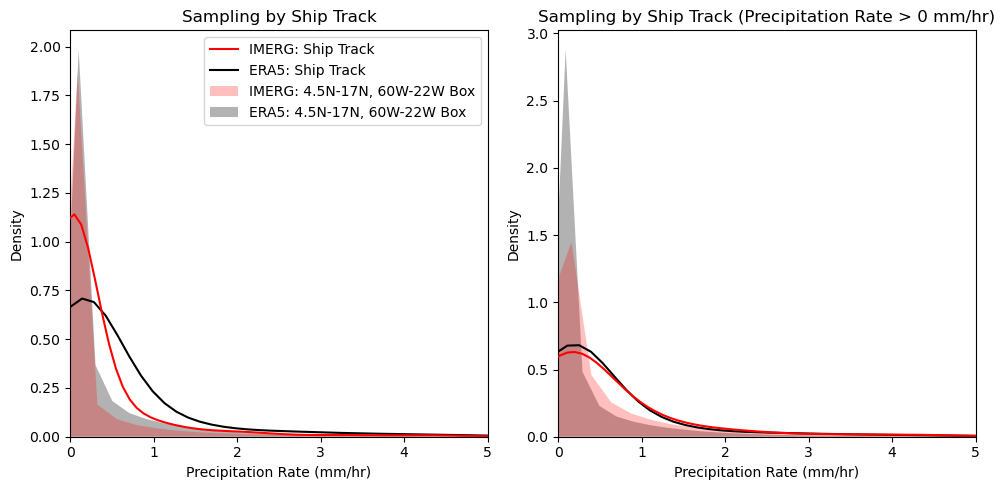

In [25]:
# Create probability density plots

fig, axs = plt.subplots(1,2,figsize=(10,5))

sns.kdeplot(prec_alongtrack,ax=axs[0],label='IMERG: Ship Track',fill=False, common_norm=False, color='red',zorder=4)
sns.kdeplot(prec_alongtrack_era5*3600,ax=axs[0],label='ERA5: Ship Track',fill=False, common_norm=False, color='black',zorder=3)
sns.kdeplot(prec_box.values.flatten(),ax=axs[0],label='IMERG: 4.5N-17N, 60W-22W Box',fill=True,common_norm=False, color='red', alpha=0.25,linewidth=0,zorder=2)
sns.kdeplot(prec_box_era5.values.flatten()*3600,ax=axs[0],label='ERA5: 4.5N-17N, 60W-22W Box',fill=True,common_norm = True, color='black',alpha=0.3,linewidth=0,zorder=1)

axs[0].set_title('Sampling by Ship Track')
axs[0].set_xlabel('Precipitation Rate (mm/hr)')
axs[0].set_ylabel('Density')
axs[0].legend(loc='upper right')
#axs[0].set_xscale('symlog')
axs[0].set_xlim(0,5)
#axs[0].set_ylim(0,1)

#sns.kdeplot(prec_alongtrack[PW_alongtrack>48],ax=axs[1],label='IMERG: Ship Track',fill=False, common_norm=False, color='red',zorder=4)
#sns.kdeplot(prec_alongtrack_era5[PW_alongtrack_era5>48]*3600,ax=axs[1],label='ERA5: Ship Track',fill=False, common_norm=False, color='black',zorder=3)
#sns.kdeplot(prec_box.values[PW_box.values>48],ax=axs[1],label='IMERG: 4.5N-17N, 60W-22W Box',fill=True,common_norm=False, color='red',alpha=0.25,linewidth=0,zorder=2)
#sns.kdeplot(prec_box_era5.values[PW_box_era5.values>48]*3600,ax=axs[1],label='ERA5: 4.5N-17N, 60W-22W Box',fill=True,common_norm=False,color='black',alpha=0.3,linewidth=0,zorder=1)

sns.kdeplot(prec_alongtrack[prec_alongtrack>0],ax=axs[1],label='IMERG: Ship Track',fill=False, common_norm=False, color='red',zorder=4)
sns.kdeplot(prec_alongtrack_era5[prec_alongtrack_era5>0]*3600,ax=axs[1],label='ERA5: Ship Track',fill=False, common_norm=False, color='black',zorder=3)
sns.kdeplot(prec_box.values[prec_box.values>0],ax=axs[1],label='IMERG: 4.5N-17N, 60W-22W Box',fill=True,common_norm=False, color='red',alpha=0.25,linewidth=0,zorder=2)
sns.kdeplot(prec_box_era5.values[prec_box_era5.values>0]*3600,ax=axs[1],label='ERA5: 4.5N-17N, 60W-22W Box',fill=True,common_norm=False,color='black',alpha=0.3,linewidth=0,zorder=1)

axs[1].set_title('Sampling by Ship Track (Precipitation Rate > 0 mm/hr)')
axs[1].set_xlabel('Precipitation Rate (mm/hr)')
axs[1].set_ylabel('Density')
#axs[1].set_xscale('log')
#axs[1].set_xlim(left=1e-1)
#axs[1].legend(loc='upper left')
axs[1].set_xlim(0,5)

plt.tight_layout()
plt.show()

fig.savefig('../figures/Fig_prec_sampling.png')

In [84]:
np.min(prec_box)

<xarray.DataArray 'precipitation' ()> Size: 8B
array(-1.79279596e-07)

# Compare MIMIC-TPW and ERA-5 to radiosondes

Extract MIMIC-TPW and ERA-5 data at times of radiosondes

In [30]:
# Times of radiosondes (where we have kept CWV data)
times_asc_finite = times_asc[finite]

# Find ship lat/lon at those times
ship_lat_asc = np.interp(times_asc_finite.astype('datetime64[ns]').astype('float64'),DSHIP.time.astype('datetime64[ns]').astype('float64'),DSHIP.lat)
ship_lon_asc = np.interp(times_asc_finite.astype('datetime64[ns]').astype('float64'),DSHIP.time.astype('datetime64[ns]').astype('float64'),DSHIP.lon)

# Extract MIMIC-TPW at those times and locations
PW_alongsondes_mimic = np.full(len(ship_lat_asc),np.nan)

for itime in range(0,len(ship_lat_asc)):
    PW_alongsondes_mimic[itime] = mimic.tpwGrid.sel(lat=ship_lat_asc[itime],lon=ship_lon_asc[itime],time=times_asc_finite[itime],method='nearest')

# Extract ERA5 at those times and locations
PW_alongsondes_era5 = np.full(len(ship_lat_asc),np.nan)

for itime in range(0,len(ship_lat_asc)):
    PW_alongsondes_era5[itime] = era5.tcwv.sel(latitude=ship_lat_asc[itime],longitude=ship_lon_asc[itime],valid_time=times_asc_finite[itime],method='nearest')

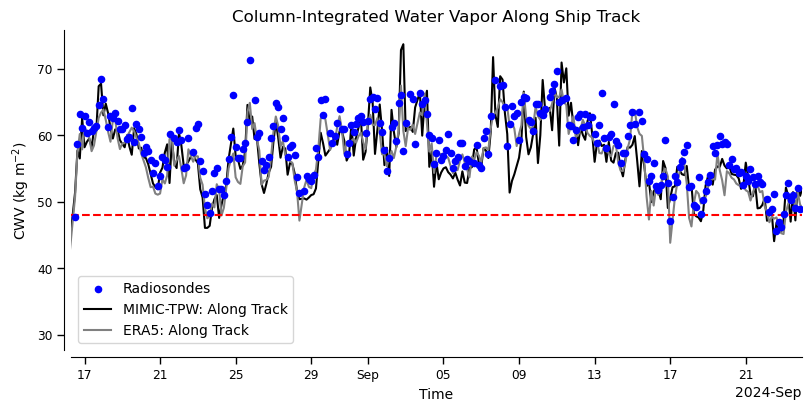

In [35]:
#plot timeseries of CWV along ship track from ERA-5 and MIMIC-TPW (interpolated to ship positions at radiosonde times) and radiosondes

fig,ax = plt.subplots(figsize=(8,4),layout="constrained")

ax.scatter(times_asc_finite,cwv_finite,marker='o',s=20,color='blue',label='Radiosondes',zorder=3)
ax.plot(times_asc_finite,PW_alongsondes_mimic,'k',label='MIMIC-TPW: Along Track',zorder=1)
ax.plot(times_asc_finite,PW_alongsondes_era5,'gray',label='ERA5: Along Track',zorder=2)
#ax.plot(planned_time_interp,PW_alongtrack_planned,'gray',label='Planned Track')
ax.axhline(48,color='red',linestyle='--')
#ax.axvline(np.datetime64('2024-08-16T07:00:00'),color='black',linestyle='--')
ax.set_xlim(np.datetime64('2024-08-16T07:00:00'),np.datetime64('2024-09-23T23:00:00'))  

plt.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_xlabel('Time')
ax.set_ylabel('CWV (kg m$^{-2}$)')
ax.set_title('Column-Integrated Water Vapor Along Ship Track')

sns.set_context('paper') 
sns.despine(offset=5)

fig.savefig('../figures/Fig_CWV_alongtrack_timeseries.png')

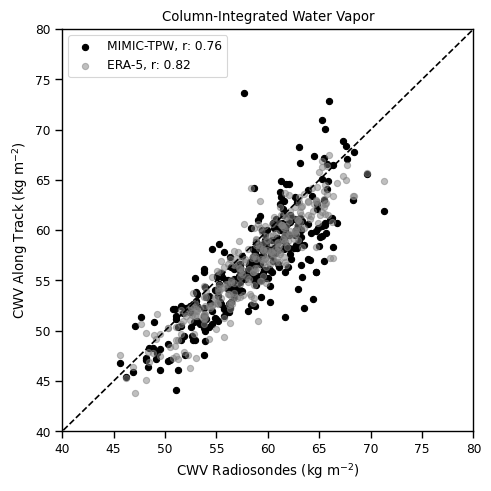

In [37]:
# Create scatter plot of CWV from radiosondes vs. MIMIC-TPW and ERA-5

# Calculate the correlation coefficient
correlation_matrix = np.corrcoef(PW_alongsondes_mimic, cwv_finite)
corr_mimic = correlation_matrix[0,1]

correlation_matrix = np.corrcoef(PW_alongsondes_era5, cwv_finite)
corr_era5 = correlation_matrix[0,1]


fig,ax = plt.subplots(figsize=(5,5))

ax.scatter(cwv_finite,PW_alongsondes_mimic,marker='o',s=20,color='black',label=f'MIMIC-TPW, r: {corr_mimic:.2f}')
ax.scatter(cwv_finite,PW_alongsondes_era5,marker='o',s=20,alpha=0.5,color='gray',label=f'ERA-5, r: {corr_era5:.2f}')
ax.plot([0,100],[0,100],'k--')

ax.set_xlabel('CWV Radiosondes (kg m$^{-2}$)')
ax.set_ylabel('CWV Along Track (kg m$^{-2}$)')
ax.set_title('Column-Integrated Water Vapor')
ax.legend()

plt.tight_layout()
ax.set_xlim(40,80)
ax.set_ylim(40,80)

fig.savefig('../figures/Fig_CWV_scatter.png')


In [92]:
times_asc_finite

array(['2024-08-14T21:00', '2024-08-15T12:00', '2024-08-15T21:00',
       '2024-08-16T12:00', '2024-08-16T15:00', '2024-08-16T18:00',
       '2024-08-16T21:00', '2024-08-17T00:00', '2024-08-17T03:00',
       '2024-08-17T06:00', '2024-08-17T09:00', '2024-08-17T12:00',
       '2024-08-17T15:00', '2024-08-17T18:00', '2024-08-17T21:00',
       '2024-08-18T00:00', '2024-08-18T03:00', '2024-08-18T06:00',
       '2024-08-18T09:00', '2024-08-18T12:00', '2024-08-18T15:00',
       '2024-08-18T18:00', '2024-08-18T21:00', '2024-08-19T00:00',
       '2024-08-19T03:00', '2024-08-19T06:00', '2024-08-19T09:00',
       '2024-08-19T12:00', '2024-08-19T15:00', '2024-08-19T18:00',
       '2024-08-19T21:00', '2024-08-20T00:00', '2024-08-20T03:00',
       '2024-08-20T06:00', '2024-08-20T09:00', '2024-08-20T12:00',
       '2024-08-20T15:00', '2024-08-20T18:00', '2024-08-20T21:00',
       '2024-08-21T00:00', '2024-08-21T03:00', '2024-08-21T06:00',
       '2024-08-21T09:00', '2024-08-21T12:00', '2024-08-21T15: